In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

2024-04-16 07:56:41.192553: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-16 07:56:41.226962: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 07:56:41.226983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 07:56:41.227843: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-16 07:56:41.233556: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)

CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [3]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm2_water_newsurf.dat')
data_clear=parse.parse('cloudrm2_clear_newsurf.dat')
data_ice=parse.parse('cloudrm2_ice_newsurf.dat')
data_mixed=parse.parse('cloudrm2_mixed_newsurf.dat')

#data_black_water=parse.parse('cloudrm_water_black_surf.dat')
#data_black_clear=parse.parse('cloudrm_clear_black_surf.dat')
#data_black_ice=parse.parse('cloudrm_ice_black_surf.dat')
#data_black_mixed=parse.parse('cloudrm_mixed_black_surf.dat')

#Concatinate all datasets
#data_all=pd.concat([data_water,data_clear,data_ice,data_mixed,
#                    data_black_water,data_black_clear,data_black_ice,data_black_mixed])

data_all=pd.concat([data_water,data_clear,data_ice,data_mixed])

data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
data_all=data_all.reset_index()
data_all=data_all.drop(columns=('index'))

df=data_all.copy()

##Train test validation split##
#X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
#           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
#           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13','Sun_Zenith_Angle']
#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05',
              'Clear_B06','Clear_B07','Clear_B08', 'Clear_B09',
              'Clear_B10','Clear_B11','Clear_B12','Clear_B13']
#clear_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05',
#              'Clear_B06','Clear_B07','Clear_B08', 'Clear_B09',
#              'Clear_B10','Clear_B11','Clear_B12','Clear_B13']

#y_labels= ['OCloud_B02','OCloud_B03','OCloud_B04','OCloud_B05','OCloud_B06',
#           'OCloud_B07','OCloud_B08','OCloud_B09','OCloud_B10','OCloud_B11','OCloud_B12','OCloud_B13']

#df[y_labels]=df[X_labels].to_numpy()-df[clear_labels].to_numpy()

quantiles=np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

In [4]:
import numpy as np


In [5]:
## Estimate COT ##
from cot_train.utils import StatCollector, MLP5, mlp_inference
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_load_paths=['cot_model_new_surf/0/model_it_2000000','cot_model_new_surf/1/model_it_2000000',
                  'cot_model_new_surf/2/model_it_2000000','cot_model_new_surf/3/model_it_2000000',
                  'cot_model_new_surf/4/model_it_2000000']

input_dim = 13
output_dim = 1

models_cot=[]
for model_path in model_load_paths:
    model_cot = MLP5(input_dim, output_dim, apply_relu=True)
    model_cot.load_state_dict(torch.load(model_path, map_location=device))
    model_cot.to(device)
    models_cot.append(model_cot)

means=[0.538923,0.530993,0.579427,0.630218,0.759563,0.807696,0.767415,0.839607,0.402664,0.066681,0.442786,0.344600,58.065838]
stds=[0.199267,0.175733,0.179156,0.165408,0.157317,0.157984,0.151002,0.158407,0.232892,0.096684,0.313212,0.220723,15.569941]

inputs = (df[X_labels].to_numpy() - means) / stds

image_input_tens=torch.Tensor(inputs).to(device)
#image_pred_cot=model_cot(image_input_tens).cpu().data.numpy()*50

preds = 0
for model_cot in models_cot:
    curr_preds=model_cot(image_input_tens)/len(models_cot)
    preds=preds+curr_preds

image_pred_cot=preds.cpu().data.numpy()*50 #unnormalise

## Reshape back
t_is_cloud = 0.025*50 # From Alex
t_thin_cloud = 0.015*50 # From Alex

im_pred_cot_t=image_pred_cot.copy()
im_pred_cot_t[im_pred_cot_t<t_thin_cloud]=0
im_pred_cot_t[(im_pred_cot_t>t_thin_cloud)&(im_pred_cot_t<t_is_cloud)]=1
im_pred_cot_t[im_pred_cot_t>t_is_cloud]=2
column_name='COT_est'
c1='clear'
c2='thin'
c3='thick'
df[column_name]=im_pred_cot_t
df.loc[df[column_name]==0,c1]=1
df.loc[df[column_name]!=0,c1]=0
df.loc[df[column_name]==1,c2]=1
df.loc[df[column_name]!=1,c2]=0
df.loc[df[column_name]==2,c3]=1
df.loc[df[column_name]!=2,c3]=0

X_labels.append(c1)
X_labels.append(c2)
X_labels.append(c3)

In [6]:
df

,Cloud_B02,Cloud_B03,Cloud_B04,Cloud_B05,Cloud_B06,Cloud_B07,Cloud_B08,Cloud_B09,Cloud_B10,Cloud_B11,...,Azimuth_Diff_Angle,COT,Cloud_Type,Profile_ID,GOT,Water_Vapor,COT_est,clear,thin,thick
0,0.57804,0.51792,0.54680,0.56000,0.56824,0.57365,0.56583,0.57950,0.37962,0.01949,...,48.59,25.181,3,9543,0.122,0.56,2.0,0.0,0.0,1.0
1,0.28975,0.25479,0.29171,0.32868,0.40295,0.44817,0.45809,0.50999,0.17019,0.00067,...,176.23,1.730,2,3672,0.116,0.77,2.0,0.0,0.0,1.0
2,0.71170,0.68907,0.73376,0.76922,0.81416,0.83261,0.83383,0.85262,0.63399,0.10050,...,16.45,20.746,4,3564,0.124,0.23,2.0,0.0,0.0,1.0
3,0.30316,0.32260,0.39997,0.43564,0.48821,0.52882,0.53207,0.58302,0.22735,0.00072,...,96.60,0.721,1,2993,0.122,0.83,0.0,1.0,0.0,0.0
4,0.84968,0.80047,0.83504,0.80686,0.83849,0.86902,0.80830,0.88989,0.26912,0.00051,...,79.44,49.984,3,6226,0.127,4.57,2.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0.33517,0.36722,0.34534,0.47953,0.72414,0.78270,0.79313,0.82834,0.55172,0.08128,...,45.61,2.744,7,3085,0.113,0.18,2.0,0.0,0.0,1.0
199996,0.52742,0.52059,0.54722,0.58774,0.69743,0.73361,0.71915,0.74644,0.52042,0.26531,...,63.00,7.871,11,2328,0.123,0.42,2.0,0.0,0.0,1.0
199997,0.49405,0.46723,0.48214,0.54814,0.70673,0.73427,0.66943,0.75148,0.11488,0.00054,...,41.38,13.611,9,8170,0.115,1.87,2.0,0.0,0.0,1.0
199998,0.63534,0.58876,0.60883,0.66729,0.75584,0.75945,0.72334,0.75668,0.37833,0.00625,...,146.16,24.175,11,9647,0.125,0.57,2.0,0.0,0.0,1.0


In [7]:
X=df[X_labels]
y=df[y_labels]

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.1)

In [8]:
import random

val_size=0.1
validation_indices=np.array(random.sample(range(len(X_train['Cloud_B02'])), int(len(data_all['Cloud_B02'])*val_size)))
train_indices=[i for i in range(len(X_train['Cloud_B02'])) if np.any(validation_indices==i)==False]

---No improvement in 100 epochs, broke early---
Best model out of total max epochs found at epoch 382
Model all saved...


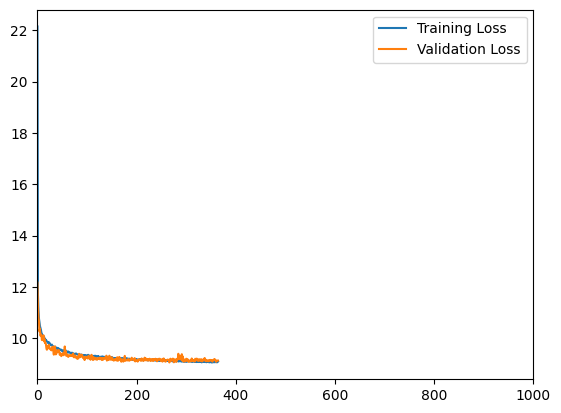

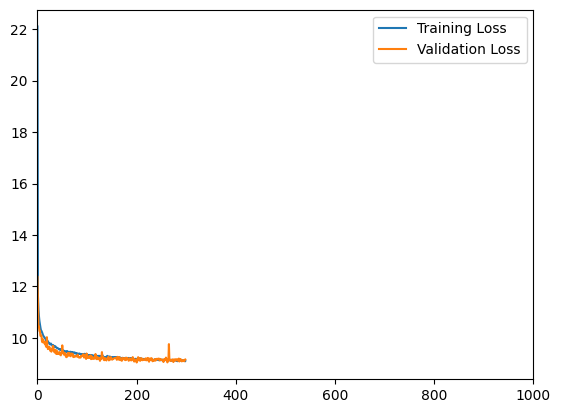

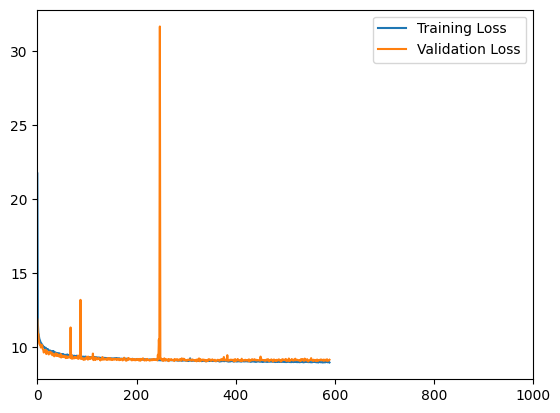

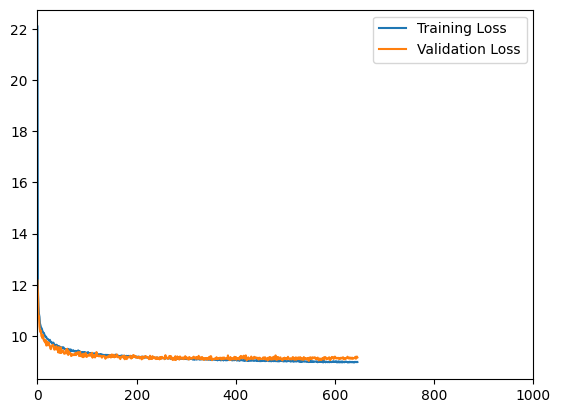

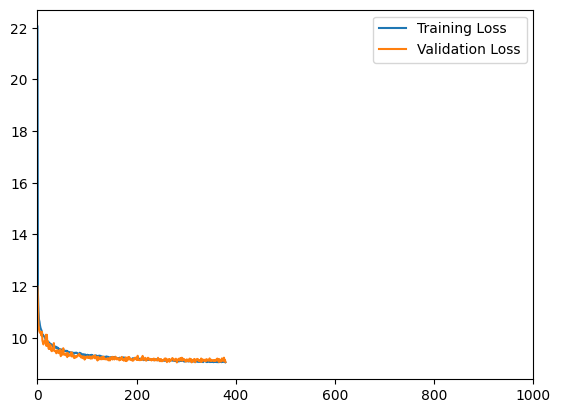

In [9]:
batch_size=500
save=True
ensamble=5

nepochs=1000
models=[QuantileNetwork(quantiles=quantiles) for i in range(ensamble)]

n_nodes_all=200

sequence_all=lambda: nn.Sequential(
    nn.Linear(len(X_labels),n_nodes_all),
    nn.ReLU(),
    nn.BatchNorm1d(n_nodes_all),
    nn.Linear(n_nodes_all,n_nodes_all),
    nn.ReLU(),
    nn.BatchNorm1d(n_nodes_all),
    nn.Linear(n_nodes_all,n_nodes_all),
    nn.ReLU(),
    nn.BatchNorm1d(n_nodes_all),
    nn.Linear(n_nodes_all,n_nodes_all),
    nn.ReLU(),
    nn.BatchNorm1d(n_nodes_all),
    nn.Linear(n_nodes_all, len(quantiles)*len(y_labels)) #Output dimesion is number of quantiles times number of target variables
)


for i,model in enumerate(models):
    main_filepath="pytorch_models/cont_test"
    model.fit(X_train.to_numpy(),y_train.to_numpy(), 
            train_indices, 
            validation_indices, 
            batch_size=batch_size,
            nepochs=nepochs,
            sequence=sequence_all(),
            lr=0.002,
            data_norm=True,
            verbose=False,
            plot_training=True,
            early_break=True)

    if save:
        filepath=main_filepath+'/model'+str(i)
        os.makedirs(filepath,exist_ok=True)
        torch.save(model,filepath+'/model_file')
        print("Model all saved...")
if save:
    X_test.to_csv(main_filepath+'/xtest.csv',index=True)
    y_test.to_csv(main_filepath+'/ytest.csv',index=True)
    df.to_csv(main_filepath+'/df.csv',index=True)


In [10]:

main_filepath='pytorch_models/cont_test'
n_ensemble=5
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))

X_test=pd.read_csv(main_filepath+'/xtest.csv',index_col=0)
y_test=pd.read_csv(main_filepath+'/ytest.csv',index_col=0)
y_true=y_test.to_numpy()

In [11]:
X_test = X_test + np.random.randn(np.shape(X_test)[0],np.shape(X_test)[1]) * np.mean(X_test.to_numpy(),axis=0)*0.03

In [12]:
for i,model in enumerate(models):
    if i==0:
        pred_y=model.predict(X_test.to_numpy())
    else:   
        pred_y=pred_y+model.predict(X_test.to_numpy())
pred_y=pred_y/len(models)

ValueError: operands could not be broadcast together with shapes (13,16) (1,13) 

In [13]:
from functions.plot_metrics import plot_metrics
from functions import calc_metrics

In [14]:
plt.rcParams["figure.figsize"] = [10, 4]
figs,axs,mses,r2s,psnrs,quantrates,quantcrosses = plot_metrics([models],
                                                                [X_test],
                                                                [y_test],
                                                                [pred_y],
                                                                df,
                                                                samples=100,
                                                                nrows=1,
                                                                ncols=2,
                                                                is_ensemble=True,
                                                                index_median=4)

NameError: name 'pred_y' is not defined

In [15]:
MSE=[]
R2=[]
PSNR=[]
quantrates=[]
quantcross=[]

MSE.append(mean_squared_error(y_true,pred_y[:,:,4]))
R2.append(r2_score(y_true,pred_y[:,:,4]))
PSNR.append(calc_metrics.PSNR(y_true,pred_y[:,:,4]))
quantrates.append(calc_metrics.quant_rate(y_true,pred_y))
quantcross.append(calc_metrics.quant_cross(pred_y))

NameError: name 'pred_y' is not defined

In [ ]:

print("MSE: "+str(MSE[0]))
print(" ")
print("R2 score: "+str(R2[0]))
print(" ")
print("PSNR: "+str(PSNR[0]))
print(" ")
print("Quantrate: "+str(quantrates[0]))
print(" ")
print("Quantile crossing: "+str(quantcross[0]))

MSE: 0.005221019274946978
 
R2 score: 0.8833250117774263
 
PSNR: 22.85239670597768
 
Quantrate: [0.06651667 0.14100833 0.22769583 0.330675   0.45596667 0.58915
 0.72877917 0.84436667 0.93355417]
 
Quantile crossing: 0.0
